In [2]:
from collections import Counter
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs
)

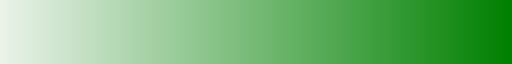

In [3]:
sns.color_palette("light:green", as_cmap=True)

In [4]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [5]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [6]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])

orf1ab = ref_df.loc[0, "translation"]
orf1a = ref_df.loc[1, "translation"]
assert orf1ab[:4401] == orf1a[:4401]
orf1b = orf1ab[4401:]

ref_df.loc[0, "translation"] = orf1b
ref_df.loc[1, "gene"] = 'ORF1a;ORF1ab'

ref_df["size"] = ref_df["translation"].str.len()
# ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation,size
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,RVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCR...,2695
1,ORF1a;ORF1ab,[pp1a],ORF1a polyprotein,YP_009725295.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,4405
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1273
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,275
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,75
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...,222
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...,61
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,121
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA,43
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,121


In [7]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,R,V,C,G,S,A,L,T,P,D,Y,F,I,N,K,Q,E,H,M,W
ORF1ab,113,228,88,149,162,179,233,182,110,178,140,142,128,151,158,88,101,70,63,32
ORF1a;ORF1ab,131,371,138,264,294,309,435,345,164,211,195,208,215,233,276,151,239,75,105,46
S,42,97,40,82,99,79,108,97,58,62,54,77,76,88,61,62,48,17,14,12
ORF3a,6,25,7,14,22,13,30,24,12,13,17,14,21,8,11,9,11,8,4,6
E,3,13,3,1,8,4,14,4,2,1,4,5,3,5,2,0,2,0,1,0
M,14,12,4,14,15,19,35,13,5,6,9,11,20,11,7,4,7,5,4,7
ORF6,1,3,0,0,4,1,8,3,1,4,2,3,10,4,4,3,5,1,3,1
ORF7a,5,8,6,4,7,9,15,10,6,2,5,10,8,2,7,5,8,3,1,0
ORF7b,0,1,2,0,2,2,11,1,0,2,1,6,5,1,0,1,3,2,2,1
ORF8,4,12,7,5,9,5,10,5,7,7,7,8,10,2,5,6,6,4,1,1


In [ ]:
# check genome size (CDS)
aa_freqs_df.sum(1).sum()*3

np.int64(29244)

In [13]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()

with open('data/ref_aa_freqs_mean.json', 'w') as f:
    json.dump(aa_freqs_total_dct, f)

aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

In [14]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


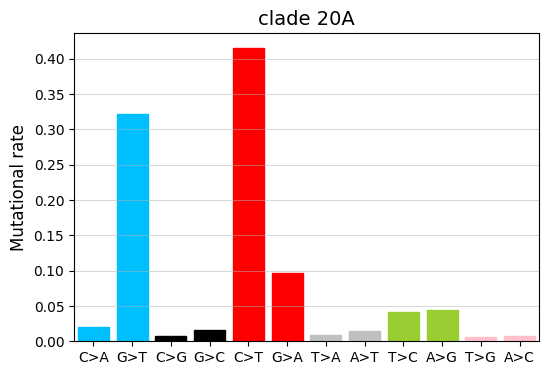

In [ ]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', ticksize=10,
            #    savepath='./figures/20A_spectrum.png'
)

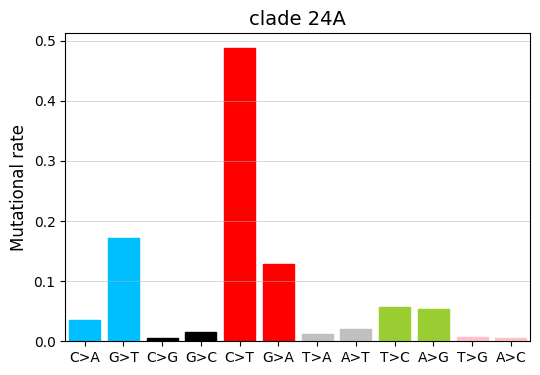

In [18]:
ax = plot_mutspec12(spectrum_24A, 'rate', 'clade 24A', 
               ylabel='Mutational rate', ticksize=10,
            #    savepath='./figures/20A_spectrum.png'
)

In [15]:
spectrum_20A_dct = spectrum_20A.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_20A_dct)

## Calculate expected AA substitutions matrix 
exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)
exp_aa_subst.to_csv('data/20A/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst

,aa1,aa2,rate
0,Ala,Ala,1.000000
1,Ala,Asp,0.040682
2,Ala,Glu,0.040682
3,Ala,Gly,0.028605
4,Ala,Pro,0.062066
...,...,...,...
163,Val,Ile,0.291929
164,Val,Leu,0.706215
165,Val,Met,0.097310
166,Val,Phe,0.644149


## Spectrum of amino acid substitutions

In [21]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

20A


/tmp/ipykernel_63679/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_63679/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


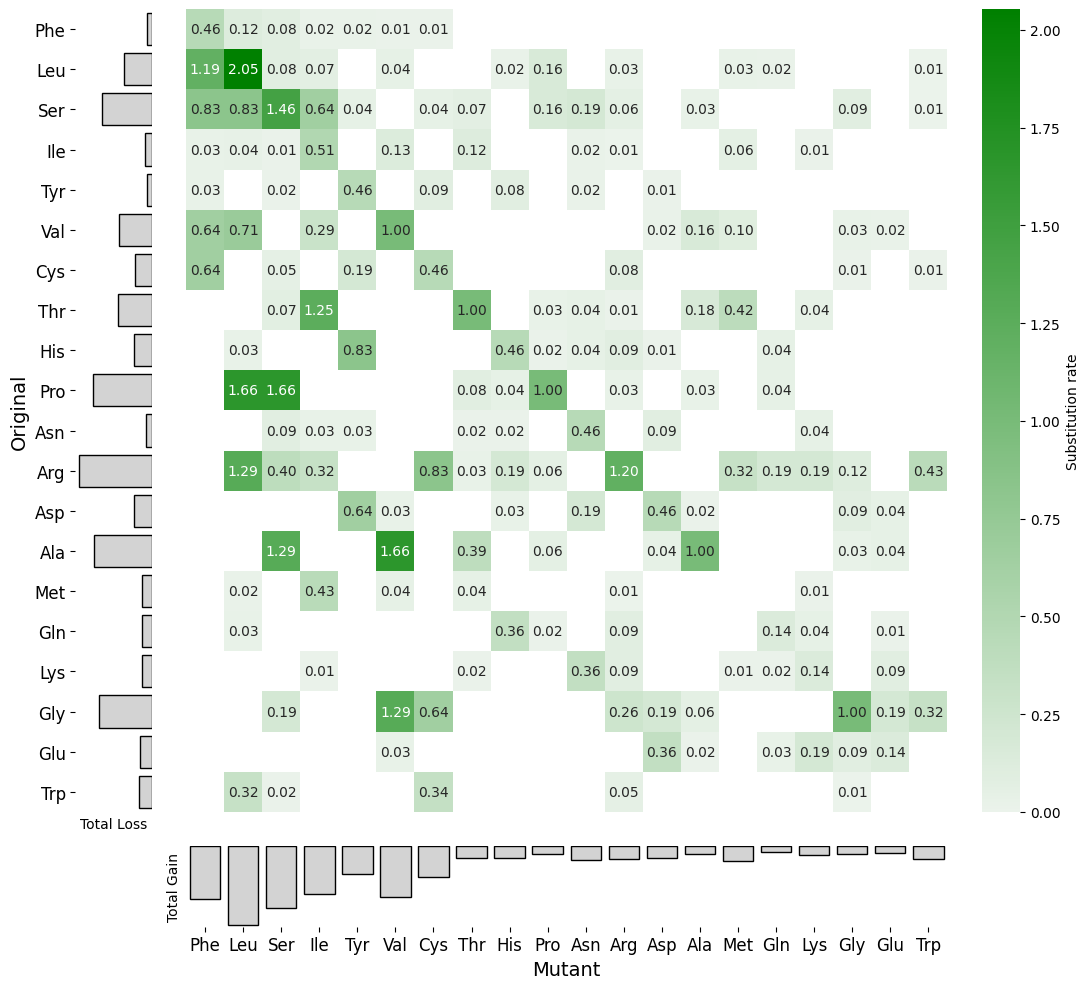

In [ ]:
print('20A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)
_, eq_freqs_aa = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)

plot_exp_heatmap(exp_aa_subst_matrix.loc[eq_freqs_aa.aa, eq_freqs_aa.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

In [ ]:
freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow20a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

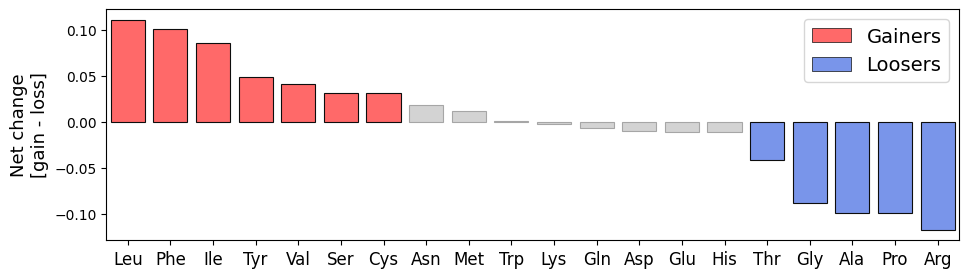

In [ ]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow20a, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow20a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change\n[gain - loss]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

24A


/tmp/ipykernel_68146/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_68146/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


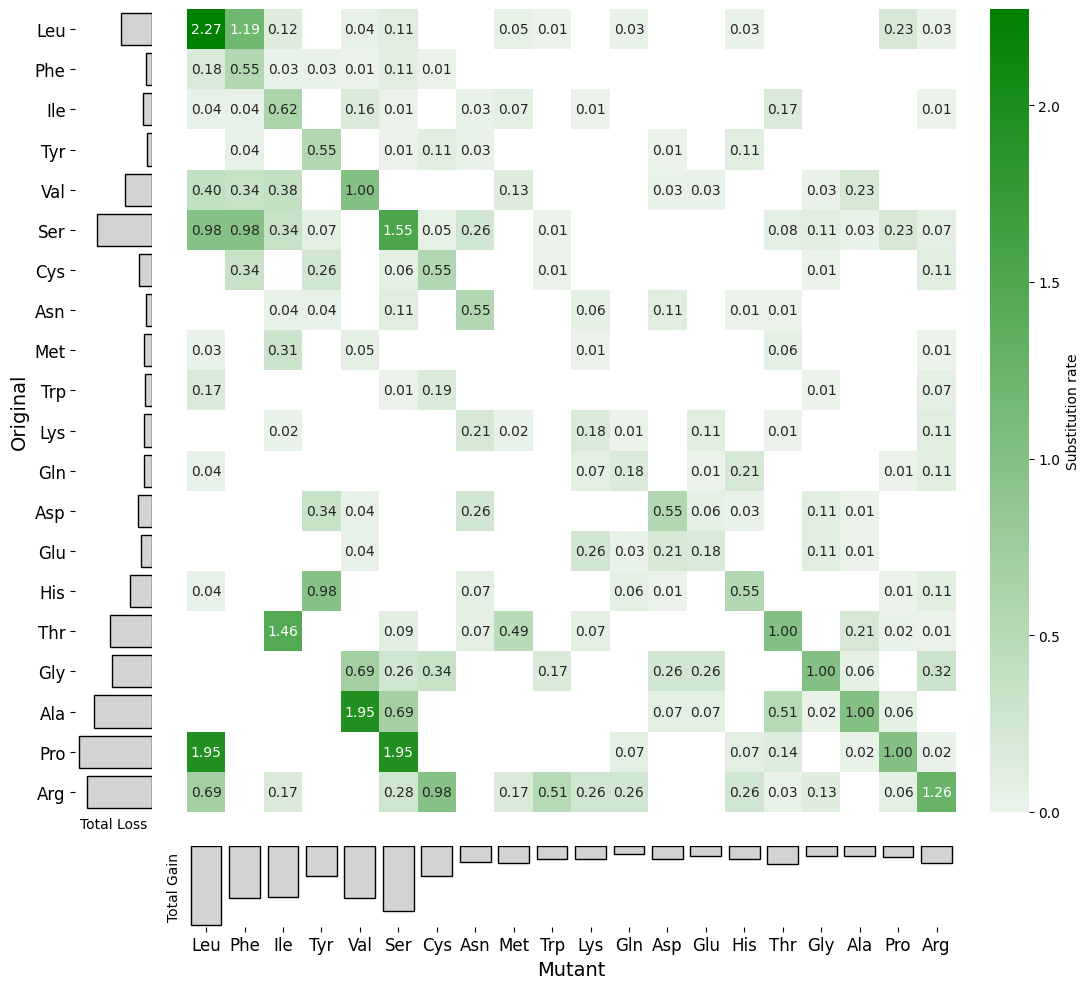

In [ ]:
print('24A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_24A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow24a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow20a.aa, flow20a.aa], # order as in 20A
                 'figures/exp_exp_aa_subst_matrix_24A.pdf', show=True, annot=True)

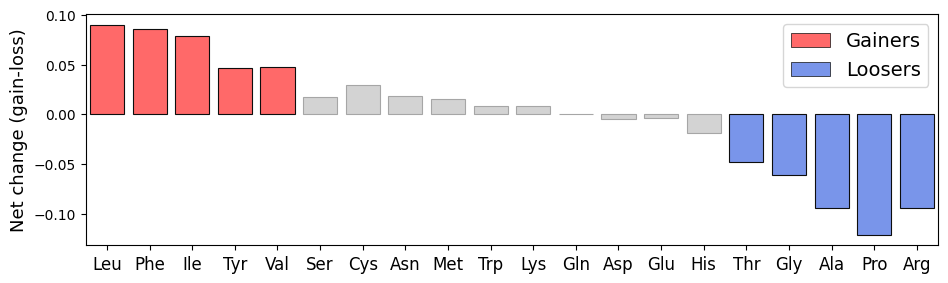

In [ ]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow24a, x='aa', y='Flow', order=flow20a.aa,
    color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow24a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change (gain-loss)', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

## Calculate amino acid equilibrium frequencies

In [26]:
## Calculate codon and AA equilibrium frequencies
eq_freqs_cdn, eq_freqc_aa = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freqs_cdn.to_csv('./data/20A/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqc_aa.to_csv('./data/20A/aa_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,eq_freq,aa
0,AAA,0.003032,Lys
1,AAC,0.003836,Asn
2,AAG,0.001522,Lys
3,AAT,0.012910,Asn
4,ACA,0.003836,Thr
...,...,...,...
59,TGT,0.029462,Cys
60,TTA,0.054818,Leu
61,TTC,0.074299,Phe
62,TTG,0.029462,Leu


In [23]:
eq_freqc_aa['obs_freq'] = eq_freqc_aa['aa'].map(aa_freqs_total_dct)
eq_freqc_aa['obs_freq'] /= eq_freqc_aa['obs_freq'].sum()
eq_freqc_aa['delta'] = (eq_freqc_aa['eq_freq'] - eq_freqc_aa['obs_freq']) / eq_freqc_aa[['eq_freq', 'obs_freq']].max(1)
eq_freqc_aa.sort_values('delta', ascending=False)

,aa,eq_freq,obs_freq,delta
0,Phe,0.314637,0.051395,0.836653
1,Leu,0.197825,0.095404,0.517735
2,Ser,0.119281,0.067809,0.431520
3,Ile,0.086898,0.052626,0.394393
4,Tyr,0.073639,0.045958,0.375899
6,Cys,0.035283,0.030365,0.139373
8,His,0.020183,0.019389,0.039367
5,Val,0.044165,0.080222,-0.449467
9,Pro,0.017862,0.040419,-0.558086
7,Thr,0.025257,0.073656,-0.657102


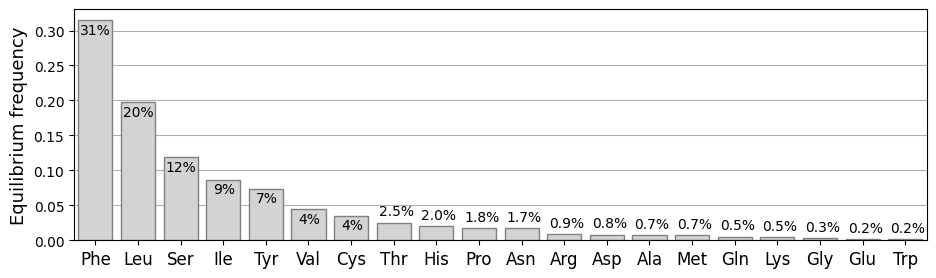

In [18]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='eq_freq', color='lightgray', edgecolor='gray')

for i, aa in enumerate(eq_freqc_aa.aa):
    f = eq_freqc_aa.query('aa == @aa').eq_freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    elif f < 0.1:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
        x = i-0.24
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

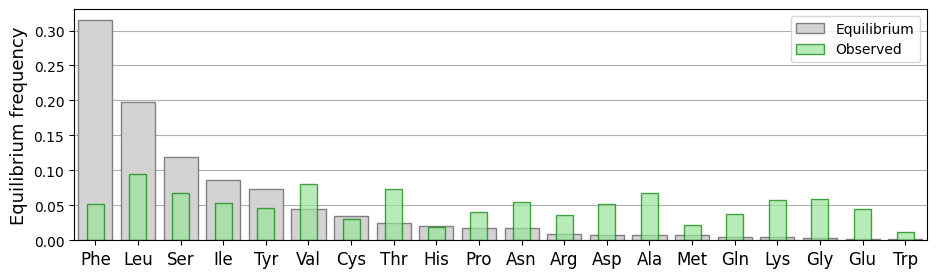

In [ ]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='eq_freq', color='lightgray', edgecolor='gray', 
               label='Equilibrium')
ax=sns.barplot(eq_freqc_aa, x='aa', y='obs_freq', color='lightgreen', edgecolor='green', 
               width=0.4, alpha=0.7, label='Observed')

plt.ylabel('Frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

Phe, Leu, Ser, Ile, Tyr, Cys and His - Global Gainers

Other AA - Global Losers

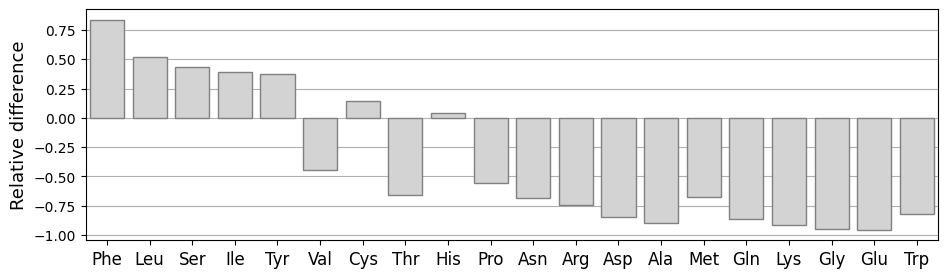

In [24]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='delta', color='lightgray', edgecolor='gray')
plt.ylabel('Relative difference', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()